In [22]:
import argparse, json, time, random
import hashlib, torch, math, pathlib
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.collections import LineCollection
from matplotlib.animation import FuncAnimation, PillowWriter
from matplotlib.ticker import FormatStrFormatter
from scipy.optimize import curve_fit
import importlib, importlib.util, os

targetinput_color = "#006838"
distractor_color = "#97211F"
analyze_network = "final"  # options: "best", "final", <parameter update step no>
noise_amplitude = 0.1  # if run analyses with noise, noise amplitude
distractor_probability = 1.0
show_figures = True  # True if running in jupyter notebook; False if running a .py file
running_from_data = True # True if code is running in the data folder next to the model.pth. if false, must run from training file

directories = [
    "data/backpropCTRNN_2DIR1O_dr100_n0.1_la0_e1_dp1.0_r1/",
    "data/backpropCTRNN_2DIR1O_dr100_n0.1_la0_e1_dp1.0_r3/",
    "data/backpropCTRNN_2DIR1O_dr100_n0.1_la0_e1_dp1.0_r5/",
    "data/hdgating_and_inversionCTRNN_2DIR1O_dr100_n0.1_la0_e1_dp1.0_r0/",
    "data/hdgating_and_reshuffle_fCTRNN_2DIR1O_dr100_n0.1_la0_sa130_e1_dp1.0_r0/",
    "data/hdgatingCTRNN_2DIR1O_dr100_n0.1_la0_e1_dp1.0_r0/",
    "data/hdinversionCTRNN_2DIR1O_dr100_n0.1_la0_e1_dp1.0_r0/",
    "data/hdratioCTRNN_2DIR1O_dr100_n0.1_la0_e1_dp1.0_r0/",
    "data/hdreshuffle_fCTRNN_2DIR1O_dr100_n0.1_la0_sa130_e1_dp1.0_r0/",
    "data/hdreshuffle_fCTRNN_2DIR1O_dr100_n0.1_la0_sa130_e1_dp1.0_r1/",
    "data/backpropCTRNN_2DIR1O_dr100_n0.1_la0_e1_dp0.0_r0/",
]
directories = [
    f"data/hdgating_and_inversionCTRNN_2DIR1O_dr100_n0.1_la0_e1_dp1.0_r{i}/" for i in range(10)
]
directories = ["data/backpropCTRNN_2DIR1O_dr100_n0.1_la0_e1_dp1.0_r3/"]
figure_dir_prefix = "paper_figures/example_networks/"

In [36]:
def _calc_pref_ave(units_i, timestep_from, timestep_to, to=1, data=None, round_prefs=False, smoothing_constant=0.01):
    """
        Calculate the preferred direction of a given neuron across a window given
    """
    if data is None: data = ao_data
    w = torch.sum(data[timestep_from:timestep_to][:, units_i], dim=(0, 4-to)).detach().numpy()
    a = np.angle(np.sum(w*np.exp(1j*(np.arange(ORI_SET_SIZE)/ORI_SET_SIZE*2*np.pi)).reshape(1, -1), axis=1)/ (np.sum(np.abs(w), axis=1)+smoothing_constant)) * 180 / np.pi
    a[a<0] = a[a<0]+360
    a = torch.tensor(a)
    if round_prefs: a = torch.round(a)
    return a
    
def generate_behavioral_figure(behavior_repeats = 10):
    """
        Generates the error rates of the network across the different "time to distractor"
        values and the Near and Far conditions

        behavior_repeats is the number of samples for every condition
    """
    delay1s = np.array([10, 15, 20, 25, 30, 90])
    noise_amplitude_c = noise_amplitude*1
    
    def make_all_integer_directions_batch(delay0, delay1, delay2, resolution=1, distractor_probability=1, repeats=1, condition='near'):
        batch = []  # inputs in the batch
        batch_labels = []  # target outputs in the batch
        output_masks = []  # masks in the batch
        for i in range(repeats):
            for direction1 in np.arange(8)/8*360:
                for direction2 in np.arange(8)/8*360:
                    diff = direction2-direction1
                    if diff < -180: diff += 360
                    if diff > 180: diff -= 360
                    diff = abs(diff)
                    if condition == 'near' and diff != 45: continue
                    if condition == 'far' and diff != 135 and diff != 180: continue
                    
                    i_full, o_full, b_mask = task._make_trial(direction1, direction2, delay0, delay1, delay2, distractor_probability=distractor_probability)
                    batch.append(i_full.unsqueeze(0))
                    batch_labels.append(o_full.unsqueeze(0))
                    output_masks.append(b_mask.unsqueeze(0))
        return torch.cat(batch), torch.cat(batch_labels), torch.cat(output_masks)
        
    repeats = behavior_repeats
    errors = {'near': {'rates': [], 'angles': []}, 'far': {'rates': [], 'angles': []}}
    for condition in ['near', 'far']:
        for delay1 in delay1s:
            ao_input, ao_target, ao_mask = make_all_integer_directions_batch(delay0, delay1, delay2, distractor_probability=1, repeats=repeats, condition=condition)
            ao_noise_mask = task.get_noise_mask(delay0, delay1, delay2)
            ao_noise_mask = ao_noise_mask.repeat(ao_input.shape[0], 1).unsqueeze(2).repeat(1, 1, model.dim_recurrent)  # convert to (batch_size, total_time, dim_recurrent)
            ao_noise = torch.randn_like(ao_noise_mask) * ao_noise_mask * noise_amplitude_c
            ao_output, ao_h = model.forward(ao_input, noise=ao_noise)
            t5 = delay0 + delay2 + task_parameters["show_direction_for"]
            t6 = t5 + task_parameters["show_cue_for"]
            _, _, e, _ = task.calculate_errors(ao_target, ao_output, ao_mask, t5, t6)
            errors[condition]['angles'].append(e)

            o1_o, _ = task.convert_sincos_to_angles(ao_output, t5, t6)
            o1_t, _ = task.convert_sincos_to_angles(ao_target, t5, t6)
            wrong = torch.minimum(torch.minimum(torch.abs(o1_o-o1_t), torch.abs(o1_o-o1_t+360)), torch.abs(o1_o-o1_t-360))>22.5
            wrong = torch.sum(wrong, dim=1)>wrong.shape[1]/2
            wrong = torch.sum(wrong)/wrong.shape[0]*100
            errors[condition]['rates'].append(wrong)

    delay1s_labels = delay1s.copy()
    delay1s_labels[-1]=40
    min_indices = [0, 2, 4, 5]

    for suffix2, condition in {'': 'rates', '_angles': 'angles'}.items():
        for suffix1, indices in {'': range(len(delay1s)), '_min': min_indices}.items():
            fig = plt.figure(figsize=(4, 4))
            plt.rc('font', **{'family': 'Arial', 'weight': 'normal', 'size': 14})
            plt.plot(delay1s_labels[indices], np.array(errors['near'][condition])[indices], "k-", linewidth=2, marker="o", markersize=9, label="Near")
            plt.plot(delay1s_labels[indices], np.array(errors['far'][condition])[indices], "--", color="k", linewidth=2, marker="^", markersize=10, label="Far")
            plt.xlabel("time to distractor (ms)")
            if condition == 'rates':
                plt.ylabel("error rate (%)")
            else:
                plt.ylabel("average error", fontsize=17)
                plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.1f°'))
                
            plt.legend()
            plt.ylim(0, max(max(errors['near'][condition]), max(errors['far'][condition]))*1.1)
            plt.xlim(6.5, 43.5)
            plt.xticks(delay1s_labels[min_indices], delay1s[min_indices]*10)
            plt.gca().spines['top'].set_visible(False)
            plt.gca().spines['right'].set_visible(False)
            plt.savefig(f'{figure_dir_prefix}{directory[5:-1]}_behavior{suffix1}{suffix2}.pdf', bbox_inches='tight')
            plt.clf()

def generate_activity_figure(vmax=1, trial_input=16, trial_distractor=20):
    """
        Generate a heatmap of activities of all artificial neurons
        for an example trial
    """
    fig = plt.figure(figsize=(5, 3))
    plt.rc('font', **{'family': 'Arial', 'weight': 'normal', 'size': 14})
    
    timesteps_to_take = np.concatenate((range((t3+t4)//2), range(t4, (t5+t6)//2)))
    data_to_show = ao_data[0:t5, torch.cat((DT_i, R1_i, )), trial_input, trial_distractor].T
    
    plt.imshow(data_to_show*1, cmap='gray_r', vmin=0, vmax=vmax,interpolation='nearest', aspect='auto')
    ax = plt.gca()
    ax.axvspan(t1, t2, facecolor=targetinput_color, alpha=0.2)
    ax.axvspan(t3, t4, facecolor=distractor_color, alpha=0.2)
    handles, labels = plt.gca().get_legend_handles_labels()
    handles.append(mpatches.Patch(color=targetinput_color, alpha=0.3, label='target'))
    handles.append(mpatches.Patch(color=distractor_color, alpha=0.3, label='distractor'))
    plt.ylabel("neuron #")
    plt.xlabel("time")
    cb = plt.colorbar(ticks=[0, vmax])
    cb.set_label("activity", labelpad=-10)
    plt.xticks([0, t1, t3, t5])
    plt.xticks([])
    plt.xlim(10, t5-60)
    ax.legend(fontsize=12, handles=handles, loc=9)
    plt.yticks([0, 20, 40, 60, 80, 100])
    plt.yticks([])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    plt.savefig(f'{figure_dir_prefix}{directory[5:-1]}_activity.pdf', bbox_inches='tight')
    plt.clf()

def generate_prefchange_figure():
    """
        Generates the histogram of absolute directional preference change of the artificial neurons
    """
    fig = plt.figure(figsize=(3, 3))
    plt.rc('font', **{'family': 'Arial', 'weight': 'normal', 'size': 14})
    ylim = 99
    ax = fig.add_subplot(1, 1, 1)
    bins = 5
    units_i = R1_i
    cue_from, cue_to = t1, t2
    delay_from, delay_to = t2+20, t3
    prefc = _calc_pref_ave(units_i, cue_from, cue_to, to=1)-_calc_pref_ave(units_i, delay_from, delay_to, to=1)
    prefc[prefc<-180] = prefc[prefc<-180]+360
    prefc[prefc>180] = prefc[prefc>180]-360
    prefc = torch.abs(prefc)
    hist = torch.histc(prefc, bins = bins, min = 0, max = 180)
    hist /= torch.sum(hist)
    x = torch.arange(bins)/bins * 180
    ax.bar(x*1.033+16, hist*100, align='center', width=180/bins/1.05, color="green")
    plt.gca().xaxis.set_major_formatter(FormatStrFormatter('%d°'))
    ax.set_xlabel('preference change')
    ax.set_ylabel('% of neurons')
    ax.set_xticks(torch.arange(0, 181, 45))
    ax.set_ylim(0, ylim)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.tight_layout()
    plt.savefig(f'{figure_dir_prefix}{directory[5:-1]}_prefchange.pdf', bbox_inches='tight')
    plt.clf()

def generate_gif_animation():
    """
        Generates the gif animation of the activities of artificial neurons
        in the network for one example trial. A visualization of bump attractor & dynamis
    """
    #TWO RINGS
    def make_all_integer_directions_batch(delay0, delay1, delay2, resolution=100, distractor_probability=1):
        batch = []  # inputs in the batch
        batch_labels = []  # target outputs in the batch
        output_masks = []  # masks in the batch
        for direction1 in np.arange(resolution)/resolution*360:
            for direction2 in [0]:
                i_full, o_full, b_mask = task._make_trial(direction1, direction2, delay0, delay1, delay2, distractor_probability=distractor_probability)
                batch.append(i_full.unsqueeze(0))
                batch_labels.append(o_full.unsqueeze(0))
                output_masks.append(b_mask.unsqueeze(0))
        return torch.cat(batch), torch.cat(batch_labels), torch.cat(output_masks)
    ao_input, ao_target, ao_mask = make_all_integer_directions_batch(delay0, delay1, delay2, distractor_probability=0)
    ao_noise_mask = task.get_noise_mask(delay0, delay1, delay2)
    ao_noise_mask = ao_noise_mask.repeat(ao_input.shape[0], 1).unsqueeze(2).repeat(1, 1, model.dim_recurrent)  # convert to (batch_size, total_time, dim_recurrent)
    ao_noise = torch.randn_like(ao_noise_mask) * ao_noise_mask * 0.1
    ao_output, ao_h = model.forward(ao_input, noise=ao_noise)
    
    def update(t, trial=50):
        ax.clear()
        r = 1.1
        units_i = R1_i
        n_bars = len(units_i)
        theta = calc_pref(units_i, t3-1, to=1)
        x = np.cos(theta*np.pi/180)*r
        y = np.sin(theta*np.pi/180)*r
        z = np.zeros_like(x)
        dx = dy = 0.1 * np.ones_like(z)
        dz = torch.maximum(ao_h[trial, t, :][units_i], torch.tensor(0)).detach().numpy()*0.5
        if t>=t1 and t<=t2:
            ax.bar3d([0], [0], [0], [0.25], [0.25], [0.1], color="red")
        ax.bar3d(x, y, z+1, dx, dy, dz, color="lightgreen")
        r = 1
        units_i = torch.tensor([x for x in range(100) if x not in R1_i])
        n_bars = len(units_i)
        if n_bars>0:
            theta = calc_pref(units_i, t2-1, to=1)
            x = np.cos(theta*np.pi/180)*r
            y = np.sin(theta*np.pi/180)*r
            z = np.zeros_like(x)
            dx = dy = 0.1 * np.ones_like(z)
            dz = torch.maximum(ao_h[trial, t, :][units_i], torch.tensor(0)).detach().numpy()*0.5
            ax.bar3d(x, y, z, dx, dy, dz, color="lightblue")
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        ax.axis('off')
        ax.set_zlim(0, 1.5)
    
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ani = FuncAnimation(fig, update, frames=range(t1-10, t3), repeat=True)
    writer = PillowWriter(fps=7)
    ani.save(f'{figure_dir_prefix}{directory[5:-1]}_animation.gif', writer=writer)
    plt.clf()

def generate_functional_connectivity_plot(dir_prefix=None):
    """
        Generates the plot
    """
    if dir_prefix is None:
        dir_prefix=figure_dir_prefix
    lim = 0.1
    # function that will be fit to the averaged connection weights
    def cosine_fit(x, a, b):
        return a * np.cos(x * np.pi / 180) + b
    
    def get_connplot_graph(units1_id=None, unit1_pref=None, units2_id=None, unit2_pref=None, sm=0):
        weight_matrix = None  # different models may store weights differently
        try:
            weight_matrix = model.fc_h2ah.weight
        except:
            weight_matrix = model.W_h_ah
        distances_weights = {}
        distances = []
        weights = []
        for i in range(len(units1_id)):
            for j in range(len(units2_id)):
                for k in range(-sm // 2, sm // 2 + 1):
                    if j == i: continue
                    diff = (unit2_pref[j] - unit1_pref[i]).item()
                    if diff > 180: diff -= 360
                    if diff < -180: diff += 360
                    diff += k
                    w_ij = weight_matrix[units2_id[j], units1_id[i]]
                    distances.append(diff)
                    weights.append(w_ij.item())
        return np.array(distances), np.array(weights)
    
    def get_connplot_iu_graph(units_id, unit_pref, sm=0):
        weight_matrix = None  # different models may store weights differently
        try:
            weight_matrix = model.fc_x2ah.weight
        except:
            weight_matrix = model.W_x_ah
        distances_weights = {}
        distances = []
        weights = []
        for i in range(len(units_id)):
            for j in range(task_parameters["input_direction_units"]):
                for k in range(-sm // 2, sm // 2 + 1):
                    # if j == i: continue
                    diff = (unit_pref[i] - round(360 * j / task_parameters["input_direction_units"])).item()
                    if diff > 180: diff -= 360
                    if diff < -180: diff += 360
                    diff += k
    
                    w_ij = weight_matrix[units_id[i], j]
                    distances.append(diff)
                    weights.append(w_ij.item())
        return np.array(distances), np.array(weights)
    
    def plot_weights(timestep_from, timestep_to, ax, weights='input', color="green", lim=0.1, fit_curves=True):
        if weights=='input':
            x, y = get_connplot_iu_graph(R1_i, _calc_pref_ave(R1_i, timestep_from, timestep_to, to=1))
        elif weights=='recurrent':
            x, y = get_connplot_graph(R1_i, _calc_pref_ave(R1_i, timestep_from, timestep_to, to=1), R1_i, _calc_pref_ave(R1_i, timestep_from, timestep_to, to=1))
        bins = np.linspace(-180, 180, 20)
        x_binned = []
        y_binned = []
        sem_binned = []
        bin_ids = np.digitize(x, bins)
        for i in range(1, len(bins)):
            x_binned.append(np.mean(x[bin_ids == i]))
            y_binned.append(np.mean(y[bin_ids == i]))
            sem_binned.append(scipy.stats.sem(y[bin_ids == i]))
        x_binned, y_binned, sem_binned = np.array(x_binned), np.array(y_binned), np.array(sem_binned) * 1.96
        ax.axhline(y=0.0, color='gray', linestyle='--', linewidth=2)
        ax.fill_between(x_binned, y_binned - sem_binned, y_binned + sem_binned, color=color, alpha=0.3, linewidth=0)
        ax.plot(x_binned, y_binned, "-", color=color, linewidth=3)
        ax.set_xlim(-180, 180)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.set_ylim(-lim * 1.1, lim * 1.1)
        ax.set_yticks([-lim, 0, lim])
        ax.set_yticks([])
        ax.set_xticks([-180, 0, 180])
        ax.xaxis.set_major_formatter(FormatStrFormatter('%d°'))
        ax.set_xlabel("∆ preferred angle")
        ax.set_yticks([-lim, 0, lim])
    
        params, covariance = curve_fit(cosine_fit, x_binned, y_binned)
        y_fit = cosine_fit(x_binned, *params)
        if fit_curves:
            ax.plot(x_binned, y_fit, "--", color=color, linewidth=3, label=f"a = {params[0]:.3f}")
        return params

    for fit_curves in [True, False]:
        fig = plt.figure(figsize=(6, 6))
        plt.rc('font', **{'family': 'Arial', 'weight': 'normal', 'size': 14})
        ax1 = fig.add_subplot(2, 2, 1)
        ax2 = fig.add_subplot(2, 2, 2)
        ax3 = fig.add_subplot(2, 2, 3)
        ax4 = fig.add_subplot(2, 2, 4)
        ax1.set_ylabel("weight")
        ax3.set_ylabel("weight")
        params_recurrent_cue = plot_weights(t1, t2, ax1, weights='recurrent', color="gray", lim=lim, fit_curves=fit_curves)
        params_recurrent_delay = plot_weights(t2+20, t3, ax2, weights='recurrent', color="k", lim=lim, fit_curves=fit_curves)
        params_input_cue = plot_weights(t1, t2, ax3, weights='input', color=targetinput_color, lim=lim, fit_curves=fit_curves)
        params_input_delay = plot_weights(t2+20, t3, ax4, weights='input', color=distractor_color, lim=lim, fit_curves=fit_curves)
        if fit_curves: 
            for ax in [ax1, ax2, ax3, ax4]: ax.legend()
        plt.tight_layout()
        plt.savefig(dir_prefix+directory[5:-1] + f"_connectivity{'_nofit' if not fit_curves else ''}.pdf", bbox_inches="tight")
        plt.clf()
    
    factors = {
        "structural_factor": params_recurrent_delay[0] / params_input_cue[0],
        "functional_factor": params_input_cue[0] / params_input_delay[0]
    }
    with open(dir_prefix+directory[5:-1] + '_connectivity.json', 'w') as f:
        json.dump(factors, f, indent=4)

def generate_exampleneuronfr_figure(neuron_i = 19):
    # Show one selected neuron
    colors = plt.cm.viridis(np.linspace(0, .9, 4))
    
    fig = plt.figure(figsize=(4, 3))
    plt.rc('font', **{'family': 'Arial', 'weight': 'normal', 'size': 14})
    
    # Loop through subplots to plot each neuron
    ax = plt.gca()
    data_means = torch.mean(ao_data[:t3, neuron_i, :, :], dim=2)
    data_sems = torch.std(ao_data[:t3, neuron_i, :, :], dim=2) / ((data_means.shape[1]-1)**0.5)
    conditions = [0, 7, 15, 23]
    for j, condition in enumerate(conditions):
        color = colors[j]
        mean = data_means[:, condition]
        sem = data_sems[:, condition]*1.96
        ax.fill_between(range(len(data_means)), mean-sem, mean+sem, color=color, alpha=0.3, linewidth=0)
        ax.plot(range(len(data_means)), mean, "-", linewidth=3, color=color, label=f"{j}")
    
    #ax.set_title(f"neuron #{neuron_index}")
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.axvspan(t1, t2, facecolor="k", alpha=0.1)
    ax.set_ylabel("activity")
    ax.set_xlabel("time (ms)")
    ax.set_xticks([t1, t2, t3])
    ax.set_xticklabels([0, 100, t3*10])
    ax.set_xlim(10, t3+5)
    #ax.set_xlim(0, 2.16)
    #ax.set_xlim(0, 2.3)
    #ax.set_ylim(0, 55)
    
    plt.tight_layout()
    plt.savefig(figure_dir_prefix+directory[5:-1] + f"_exampleneuron.pdf", bbox_inches='tight')
def generate_exampleneurontuningcurve_figure(neuron_i=19):
    cue_from, cue_to = t1, t2
    delay_from, delay_to = t2+20, t3
    
    n_conditions = ORI_SET_SIZE
    cue_data_means = np.zeros((n_conditions, ))
    cue_data_sems = np.zeros((n_conditions, ))
    delay_data_means = np.zeros((n_conditions, ))
    delay_data_sems = np.zeros((n_conditions, ))
    for i in np.arange(n_conditions):
        cue_data = torch.mean(ao_data[cue_from:cue_to, neuron_i, i, :], dim=0)
        cue_data_means[i] = torch.mean(cue_data)
        cue_data_sems[i] = scipy.stats.sem(cue_data)
        delay_data = torch.mean(ao_data[delay_from:delay_to, neuron_i, i, :], dim=0)
        delay_data_means[i] = torch.mean(delay_data)
        delay_data_sems[i] = scipy.stats.sem(delay_data)
    thetas = np.arange(n_conditions)/n_conditions*360
    
    conditions = np.arange(0, n_conditions, 1)
    thetas = thetas[conditions]
    cue_data_means = cue_data_means[conditions]
    cue_data_sems = cue_data_sems[conditions]
    delay_data_means = delay_data_means[conditions]
    delay_data_sems = delay_data_sems[conditions]
    
    thetas = np.hstack((thetas-360, thetas, thetas+360))
    cue_data_means = np.hstack((cue_data_means, cue_data_means, cue_data_means))
    cue_data_sems = np.hstack((cue_data_sems, cue_data_sems, cue_data_sems))
    delay_data_means = np.hstack((delay_data_means, delay_data_means, delay_data_means))
    delay_data_sems = np.hstack((delay_data_sems, delay_data_sems, delay_data_sems))
    
    # cue_data_sems /= np.max(cue_data_means)
    # cue_data_means /= np.max(cue_data_means)
    # delay_data_sems /= np.max(delay_data_means)
    # delay_data_means /= np.max(delay_data_means)
    
    fig = plt.figure(figsize=(4, 2.5))
    plt.rc('font', **{'family': 'Arial', 'weight': 'normal', 'size': 14})
    ax = plt.gca()
    color=targetinput_color
    ax.fill_between(thetas, cue_data_means-cue_data_sems, cue_data_means+cue_data_sems, color=color, alpha=0.3, linewidth=0, label="t=cue")
    ax.plot(thetas, cue_data_means, "-", linewidth=3, color=color)
    color=distractor_color
    ax.fill_between(thetas, delay_data_means-delay_data_sems, delay_data_means+delay_data_sems, color=color, alpha=0.3, linewidth=0, label="t=delay")
    ax.plot(thetas, delay_data_means, "-", linewidth=3, color=color)
    
    plt.xticks(np.array([-180, 0, 180, 360]))
    plt.xlim(-180, 180)
    plt.xlabel("stimulus angle")
    plt.gca().xaxis.set_major_formatter(FormatStrFormatter('%d°'))
    plt.ylim(-.1, .99)
    #ax.set_ylim(0, 55)
    plt.ylabel("activity")
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.tight_layout()
    plt.savefig(figure_dir_prefix+directory[5:-1] + f"_exampletuningcurve.pdf", bbox_inches='tight')

data/backpropCTRNN_2DIR1O_dr100_n0.1_la0_e1_dp1.0_r3/


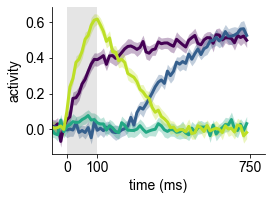

In [37]:
for _directory in directories:
    print(_directory)
    directory = _directory
    
    # Define the file path and module name
    file_path = directory + "task_and_training.py"  # Change this to your file's path
    module_name = 'task_and_training'  # Arbitrary name for the module
    # Create a module object
    spec = importlib.util.spec_from_file_location(module_name, file_path)
    module = importlib.util.module_from_spec(spec)
    # Load the module into memory and execute it
    spec.loader.exec_module(module)
    # Inject attributes into the global namespace
    for attr in dir(module):
        globals()[attr] = getattr(module, attr)
    directory = _directory  # it might have been changed by the imported file, so change it back
    
    with open(f"{directory}info.json", 'r', encoding='utf-8') as f:
        j = json.load(f)
    hyperparameters = j["hyperparameters"]
    task_parameters = j["task_parameters"]
    model_parameters = j["model_parameters"]
    additional_comments = j["additional_comments"]
    directory = j["directory"]
        
    # some noise may be necessary to prevent dividing by 0 in some of the analyses
    # if noise_amplitude == 0: noise_amplitude = 0.0001
    
    task = Task()
    model = Model()
    if analyze_network.lower() == "best": network_filename = "model_best.pth"
    elif analyze_network.lower() == "final": network_filename = f"model_parameterupdate{hyperparameters['train_for_steps']}.pth"
    else: network_filename = f"model_parameterupdate{analyze_network}.pth"
    model_state_dict = torch.load(directory+network_filename, map_location=torch.device('cpu'))["model_state_dict"]
    model.load_state_dict(model_state_dict)
    
    resolution = 30
    ORI_RES = 360//resolution
    ORI_SET = torch.arange(0, 360, ORI_RES)
    ORI_SET_SIZE = ORI_SET.shape[0]
    
    # fix delays at median values for analysis
    delay0, delay1, delay2 = task.get_median_delays()
    #delay1 = task_parameters["delay1_to"]  # max delay1 (to ensure convergence to final state for analysis)
    show_direction_for = task_parameters["show_direction_for"]
    show_cue_for = task_parameters["show_cue_for"]
    total_time = show_direction_for+show_cue_for+delay0+delay2
    t1, t1d = delay0, "before O1 presented"
    t1_5, t1_5d = delay0+show_direction_for//2, "amid 01 presentation"
    t2, t2d = delay0+show_direction_for, "after O1 presented"
    t3, t3d = delay0+show_direction_for+delay1, "before O2 presented"
    t3_5, t3_5d = delay0+show_direction_for+delay1+show_direction_for//2, "amid O2 presentation"
    t4, t4d = delay0+show_direction_for+delay1+show_direction_for, "after O2 presented"
    t5, t5d = delay0+show_direction_for+delay2, "before go cue"
    t6, t6d = total_time-1, "at end of task"
    
    # run the model on all possible directions 
    ao_input, ao_target, ao_mask = task.make_all_integer_directions_batch(delay0, delay1, delay2, distractor_probability=distractor_probability, resolution=resolution)
    ao_noise_mask = task.get_noise_mask(delay0, delay1, delay2)
    ao_noise_mask = ao_noise_mask.repeat(ao_input.shape[0], 1).unsqueeze(2).repeat(1, 1, model.dim_recurrent)  # convert to (batch_size, total_time, dim_recurrent)
    ao_noise = torch.randn_like(ao_noise_mask) * ao_noise_mask * noise_amplitude
    ao_output, ao_h = model.forward(ao_input, noise=ao_noise)
    
    # output model errors (with noise and without)
    mse_o1, mse_o2, err_o1, err_o2 = task.calculate_errors(ao_target, ao_output, ao_mask, t5, t6)
    ao_output_nn, ao_h_nn = model.forward(ao_input, noise=ao_noise*0)
    mse_o1_nn, mse_o2_nn, err_o1_nn, err_o2_nn = task.calculate_errors(ao_target, ao_output_nn, ao_mask, t5, t6)
    
    # for every timestep and every unit, calculate its activity in all trials
    ao_data = torch.zeros((total_time, model.dim_recurrent, ORI_SET_SIZE, ORI_SET_SIZE))
    for direction1 in range(ORI_SET_SIZE):
        for direction2 in range(ORI_SET_SIZE):
            o = ao_h[direction1 * ORI_SET_SIZE + direction2]
            ao_data[:, :, direction1, direction2] = o
            
    # detach from autograd
    ao_output = ao_output.detach()
    ao_h = ao_h.detach()
    ao_data = ao_data.detach()
    
    timestep, timestep_description = t5, t5d
    cutoff_criterion = "box" # options: ratio, box
    ring_cutoff = 2  # if ratio: minumum variance ratio to consider unit a ring unit
    min_pri_var = 0.15  # if box: minimum variance in primary direction to consider unit a ring unit
    max_sec_var = 0.10  # if box: maximum variance in the other direction to consider unit a ring unit
    var_1 = torch.var(torch.mean(ao_data[timestep], dim=2), dim=1)**0.5 + 0.01
    var_2 = torch.var(torch.mean(ao_data[timestep], dim=1), dim=1)**0.5 + 0.01
    if cutoff_criterion == "ratio":
        R1_i = torch.where(var_1/var_2 > ring_cutoff)[0]
        R2_i = torch.where(var_2/var_1 > ring_cutoff)[0]
        DT_i = torch.tensor([x for x in range(model.dim_recurrent) if (x not in R1_i) and (x not in R2_i)], dtype=int)
    elif cutoff_criterion == "box":
        R1_i = torch.where(torch.logical_and(var_1>min_pri_var, var_2<max_sec_var))[0]
        R2_i = torch.where(torch.logical_and(var_2>min_pri_var, var_1<max_sec_var))[0]
        DT_i = torch.tensor([x for x in range(model.dim_recurrent) if (x not in R1_i) and (x not in R2_i)], dtype=int)
    
    ##############################################################
    
    def calc_pref(units_i, timestep=t5, to=1, data=None, round_prefs=False):
        if data is None: data = ao_data
        w = torch.sum(data[timestep][units_i], dim=3-to).detach().numpy()
        a = np.angle(np.sum(w*np.exp(1j*(np.arange(ORI_SET_SIZE)/ORI_SET_SIZE*2*np.pi)).reshape(1, -1), axis=1)/ (np.sum(np.abs(w), axis=1)+0.01)) * 180 / np.pi
        a[a<0] = a[a<0]+360
        a = torch.tensor(a)
        if round_prefs: a = torch.round(a)
        return a
    prefs_1 = []  # every unit's preferred O1
    prefs_2 = []  # every unit's preferred O2
    for timestep in range(total_time):
        prefs_1.append(calc_pref(range(model.dim_recurrent), timestep=timestep, to=1).unsqueeze(0))
        prefs_2.append(calc_pref(range(model.dim_recurrent), timestep=timestep, to=2).unsqueeze(0))
    prefs_1 = torch.cat(prefs_1)
    prefs_2 = torch.cat(prefs_2)
    
    # sort units according to their preferred directions (don't sort DT)
    R1_pref = prefs_1[t5-1][R1_i]
    R2_pref = prefs_2[t5-1][R2_i]
    DT_pref = prefs_1[t2-1][DT_i]
    R1_i = R1_i.clone()[torch.argsort(R1_pref)]
    R1_pref = R1_pref.clone()[torch.argsort(R1_pref)]
    R2_i = R2_i.clone()[torch.argsort(R2_pref)]
    R2_pref = R2_pref.clone()[torch.argsort(R2_pref)]
    DT_i = DT_i.clone()[torch.argsort(DT_pref)]
    DT_pref = DT_pref.clone()[torch.argsort(DT_pref)]
    order_indices = torch.cat((R1_i, DT_i, R2_i))
    
    ##############################################################
    generate_exampleneuronfr_figure()
    generate_exampleneurontuningcurve_figure()
    plt.close()
    continue
    
    
    if 'backprop' in directory:  # change vmax and pick a different trial to show the effect more clearly
        generate_activity_figure(vmax=.7, trial_input=20, trial_distractor=16)
    else:
        generate_activity_figure()
    generate_prefchange_figure()

    plt.close()

# (Temporary) Add all structural and functional ratio info

In [11]:
directories = [f"data/backpropCTRNN_2DIR1O_dr100_n0.1_la0_e1_dp1.0_r{k}/" for k in range(30)]
for _directory in directories:
    print(_directory)
    directory = _directory
    
    # Define the file path and module name
    file_path = directory + "task_and_training.py"  # Change this to your file's path
    module_name = 'task_and_training'  # Arbitrary name for the module
    # Create a module object
    spec = importlib.util.spec_from_file_location(module_name, file_path)
    module = importlib.util.module_from_spec(spec)
    # Load the module into memory and execute it
    spec.loader.exec_module(module)
    # Inject attributes into the global namespace
    for attr in dir(module):
        globals()[attr] = getattr(module, attr)
    directory = _directory  # it might have been changed by the imported file, so change it back
    
    with open(f"{directory}info.json", 'r', encoding='utf-8') as f:
        j = json.load(f)
    hyperparameters = j["hyperparameters"]
    task_parameters = j["task_parameters"]
    model_parameters = j["model_parameters"]
    additional_comments = j["additional_comments"]
    directory = j["directory"]
        
    # some noise may be necessary to prevent dividing by 0 in some of the analyses
    # if noise_amplitude == 0: noise_amplitude = 0.0001
    
    task = Task()
    model = Model()
    if analyze_network.lower() == "best": network_filename = "model_best.pth"
    elif analyze_network.lower() == "final": network_filename = f"model_parameterupdate{hyperparameters['train_for_steps']}.pth"
    else: network_filename = f"model_parameterupdate{analyze_network}.pth"
    model_state_dict = torch.load(directory+network_filename, map_location=torch.device('cpu'))["model_state_dict"]
    model.load_state_dict(model_state_dict)
    
    resolution = 30
    ORI_RES = 360//resolution
    ORI_SET = torch.arange(0, 360, ORI_RES)
    ORI_SET_SIZE = ORI_SET.shape[0]
    
    # fix delays at median values for analysis
    delay0, delay1, delay2 = task.get_median_delays()
    #delay1 = task_parameters["delay1_to"]  # max delay1 (to ensure convergence to final state for analysis)
    show_direction_for = task_parameters["show_direction_for"]
    show_cue_for = task_parameters["show_cue_for"]
    total_time = show_direction_for+show_cue_for+delay0+delay2
    t1, t1d = delay0, "before O1 presented"
    t1_5, t1_5d = delay0+show_direction_for//2, "amid 01 presentation"
    t2, t2d = delay0+show_direction_for, "after O1 presented"
    t3, t3d = delay0+show_direction_for+delay1, "before O2 presented"
    t3_5, t3_5d = delay0+show_direction_for+delay1+show_direction_for//2, "amid O2 presentation"
    t4, t4d = delay0+show_direction_for+delay1+show_direction_for, "after O2 presented"
    t5, t5d = delay0+show_direction_for+delay2, "before go cue"
    t6, t6d = total_time-1, "at end of task"
    
    # run the model on all possible directions 
    ao_input, ao_target, ao_mask = task.make_all_integer_directions_batch(delay0, delay1, delay2, distractor_probability=distractor_probability, resolution=resolution)
    ao_noise_mask = task.get_noise_mask(delay0, delay1, delay2)
    ao_noise_mask = ao_noise_mask.repeat(ao_input.shape[0], 1).unsqueeze(2).repeat(1, 1, model.dim_recurrent)  # convert to (batch_size, total_time, dim_recurrent)
    ao_noise = torch.randn_like(ao_noise_mask) * ao_noise_mask * noise_amplitude
    ao_output, ao_h = model.forward(ao_input, noise=ao_noise)
    
    # output model errors (with noise and without)
    mse_o1, mse_o2, err_o1, err_o2 = task.calculate_errors(ao_target, ao_output, ao_mask, t5, t6)
    ao_output_nn, ao_h_nn = model.forward(ao_input, noise=ao_noise*0)
    mse_o1_nn, mse_o2_nn, err_o1_nn, err_o2_nn = task.calculate_errors(ao_target, ao_output_nn, ao_mask, t5, t6)
    
    # for every timestep and every unit, calculate its activity in all trials
    ao_data = torch.zeros((total_time, model.dim_recurrent, ORI_SET_SIZE, ORI_SET_SIZE))
    for direction1 in range(ORI_SET_SIZE):
        for direction2 in range(ORI_SET_SIZE):
            o = ao_h[direction1 * ORI_SET_SIZE + direction2]
            ao_data[:, :, direction1, direction2] = o
            
    # detach from autograd
    ao_output = ao_output.detach()
    ao_h = ao_h.detach()
    ao_data = ao_data.detach()
    
    timestep, timestep_description = t5, t5d
    cutoff_criterion = "box" # options: ratio, box
    ring_cutoff = 2  # if ratio: minumum variance ratio to consider unit a ring unit
    min_pri_var = 0.15  # if box: minimum variance in primary direction to consider unit a ring unit
    max_sec_var = 0.10  # if box: maximum variance in the other direction to consider unit a ring unit
    var_1 = torch.var(torch.mean(ao_data[timestep], dim=2), dim=1)**0.5 + 0.01
    var_2 = torch.var(torch.mean(ao_data[timestep], dim=1), dim=1)**0.5 + 0.01
    if cutoff_criterion == "ratio":
        R1_i = torch.where(var_1/var_2 > ring_cutoff)[0]
        R2_i = torch.where(var_2/var_1 > ring_cutoff)[0]
        DT_i = torch.tensor([x for x in range(model.dim_recurrent) if (x not in R1_i) and (x not in R2_i)], dtype=int)
    elif cutoff_criterion == "box":
        R1_i = torch.where(torch.logical_and(var_1>min_pri_var, var_2<max_sec_var))[0]
        R2_i = torch.where(torch.logical_and(var_2>min_pri_var, var_1<max_sec_var))[0]
        DT_i = torch.tensor([x for x in range(model.dim_recurrent) if (x not in R1_i) and (x not in R2_i)], dtype=int)
    
    ##############################################################
    
    def calc_pref(units_i, timestep=t5, to=1, data=None, round_prefs=False):
        if data is None: data = ao_data
        w = torch.sum(data[timestep][units_i], dim=3-to).detach().numpy()
        a = np.angle(np.sum(w*np.exp(1j*(np.arange(ORI_SET_SIZE)/ORI_SET_SIZE*2*np.pi)).reshape(1, -1), axis=1)/ (np.sum(np.abs(w), axis=1)+0.01)) * 180 / np.pi
        a[a<0] = a[a<0]+360
        a = torch.tensor(a)
        if round_prefs: a = torch.round(a)
        return a
    prefs_1 = []  # every unit's preferred O1
    prefs_2 = []  # every unit's preferred O2
    for timestep in range(total_time):
        prefs_1.append(calc_pref(range(model.dim_recurrent), timestep=timestep, to=1).unsqueeze(0))
        prefs_2.append(calc_pref(range(model.dim_recurrent), timestep=timestep, to=2).unsqueeze(0))
    prefs_1 = torch.cat(prefs_1)
    prefs_2 = torch.cat(prefs_2)
    
    # sort units according to their preferred directions (don't sort DT)
    R1_pref = prefs_1[t5-1][R1_i]
    R2_pref = prefs_2[t5-1][R2_i]
    DT_pref = prefs_1[t2-1][DT_i]
    R1_i = R1_i.clone()[torch.argsort(R1_pref)]
    R1_pref = R1_pref.clone()[torch.argsort(R1_pref)]
    R2_i = R2_i.clone()[torch.argsort(R2_pref)]
    R2_pref = R2_pref.clone()[torch.argsort(R2_pref)]
    DT_i = DT_i.clone()[torch.argsort(DT_pref)]
    DT_pref = DT_pref.clone()[torch.argsort(DT_pref)]
    order_indices = torch.cat((R1_i, DT_i, R2_i))
    
    ##############################################################
    if err_o1 > 15: 
        print("ERROR >15")
        continue
    generate_functional_connectivity_plot(dir_prefix="data_json/")

data/backpropCTRNN_2DIR1O_dr100_n0.1_la0_e1_dp1.0_r0/
ERROR >15
data/backpropCTRNN_2DIR1O_dr100_n0.1_la0_e1_dp1.0_r1/
data/backpropCTRNN_2DIR1O_dr100_n0.1_la0_e1_dp1.0_r2/
ERROR >15
data/backpropCTRNN_2DIR1O_dr100_n0.1_la0_e1_dp1.0_r3/
data/backpropCTRNN_2DIR1O_dr100_n0.1_la0_e1_dp1.0_r4/
ERROR >15
data/backpropCTRNN_2DIR1O_dr100_n0.1_la0_e1_dp1.0_r5/
data/backpropCTRNN_2DIR1O_dr100_n0.1_la0_e1_dp1.0_r6/
data/backpropCTRNN_2DIR1O_dr100_n0.1_la0_e1_dp1.0_r7/
data/backpropCTRNN_2DIR1O_dr100_n0.1_la0_e1_dp1.0_r8/
ERROR >15
data/backpropCTRNN_2DIR1O_dr100_n0.1_la0_e1_dp1.0_r9/
data/backpropCTRNN_2DIR1O_dr100_n0.1_la0_e1_dp1.0_r10/
data/backpropCTRNN_2DIR1O_dr100_n0.1_la0_e1_dp1.0_r11/
data/backpropCTRNN_2DIR1O_dr100_n0.1_la0_e1_dp1.0_r12/
data/backpropCTRNN_2DIR1O_dr100_n0.1_la0_e1_dp1.0_r13/
ERROR >15
data/backpropCTRNN_2DIR1O_dr100_n0.1_la0_e1_dp1.0_r14/
data/backpropCTRNN_2DIR1O_dr100_n0.1_la0_e1_dp1.0_r15/
ERROR >15
data/backpropCTRNN_2DIR1O_dr100_n0.1_la0_e1_dp1.0_r16/
ERROR >15
data/

/var/folders/47/5g669ycs2t17c0kkg2_np43m0000gn/T/ipykernel_73287/1567386492.py:308: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(6, 6))


data/backpropCTRNN_2DIR1O_dr100_n0.1_la0_e1_dp1.0_r19/
data/backpropCTRNN_2DIR1O_dr100_n0.1_la0_e1_dp1.0_r20/
data/backpropCTRNN_2DIR1O_dr100_n0.1_la0_e1_dp1.0_r21/
ERROR >15
data/backpropCTRNN_2DIR1O_dr100_n0.1_la0_e1_dp1.0_r22/
data/backpropCTRNN_2DIR1O_dr100_n0.1_la0_e1_dp1.0_r23/
data/backpropCTRNN_2DIR1O_dr100_n0.1_la0_e1_dp1.0_r24/
data/backpropCTRNN_2DIR1O_dr100_n0.1_la0_e1_dp1.0_r25/
data/backpropCTRNN_2DIR1O_dr100_n0.1_la0_e1_dp1.0_r26/
data/backpropCTRNN_2DIR1O_dr100_n0.1_la0_e1_dp1.0_r27/
data/backpropCTRNN_2DIR1O_dr100_n0.1_la0_e1_dp1.0_r28/
ERROR >15
data/backpropCTRNN_2DIR1O_dr100_n0.1_la0_e1_dp1.0_r29/


<Figure size 432x432 with 0 Axes>

<Figure size 432x432 with 0 Axes>

<Figure size 432x432 with 0 Axes>

<Figure size 432x432 with 0 Axes>

<Figure size 432x432 with 0 Axes>

<Figure size 432x432 with 0 Axes>

<Figure size 432x432 with 0 Axes>

<Figure size 432x432 with 0 Axes>

<Figure size 432x432 with 0 Axes>

<Figure size 432x432 with 0 Axes>

<Figure size 432x432 with 0 Axes>

<Figure size 432x432 with 0 Axes>

<Figure size 432x432 with 0 Axes>

<Figure size 432x432 with 0 Axes>

<Figure size 432x432 with 0 Axes>

<Figure size 432x432 with 0 Axes>

<Figure size 432x432 with 0 Axes>

<Figure size 432x432 with 0 Axes>

<Figure size 432x432 with 0 Axes>

<Figure size 432x432 with 0 Axes>

<Figure size 432x432 with 0 Axes>

<Figure size 432x432 with 0 Axes>

<Figure size 432x432 with 0 Axes>

<Figure size 432x432 with 0 Axes>

<Figure size 432x432 with 0 Axes>

<Figure size 432x432 with 0 Axes>

<Figure size 432x432 with 0 Axes>

<Figure size 432x432 with 0 Axes>

<Figure size 432x432 with 0 Axes>

<Figure size 432x432 with 0 Axes>

<Figure size 432x432 with 0 Axes>

<Figure size 432x432 with 0 Axes>

<Figure size 432x432 with 0 Axes>

<Figure size 432x432 with 0 Axes>

<Figure size 432x432 with 0 Axes>

<Figure size 432x432 with 0 Axes>

<Figure size 432x432 with 0 Axes>

<Figure size 432x432 with 0 Axes>

<Figure size 432x432 with 0 Axes>

<Figure size 432x432 with 0 Axes>